# Chapter 6 - Mikkel

## Questions:
1. Can you comment on what is happening in stick breaking? What are the $w$ in weights? What do they reflect?
2. What is the "linspace" and "transform" in the normal distribution prior?

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math
from scipy import stats
import theano
import theano.tensor as tt

sns.set_context('talk')

([], [])

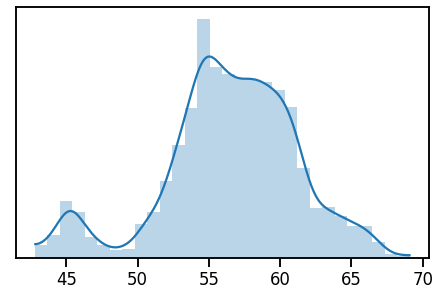

In [2]:
cs = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
cs_exp = cs['exp']
az.plot_kde(cs_exp)
plt.hist(cs_exp, density=True, bins=30, alpha=0.3)
plt.yticks([])

In [4]:
clusters = 2
with pm.Model() as model_kg: ### TERRIBLE MODEL!
    p = pm.Dirichlet('p', a=np.ones(clusters))
    z = pm.Categorical('z', p=p, shape=len(cs_exp))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.Normal('y', mu=means[z], sd=sd, observed=cs_exp)
    trace_kg = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sd, means, p]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1056 seconds.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The acceptance probability does not match the target. It is 0.881131054232538, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Explicitly modelling the latent variable $z$ is terrible for sampling, as we miss out on the tails of the distribution. PYMC3 handles this better when using a NormalMixture variable for y.

In [5]:
clusters = 2
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    trace_mg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

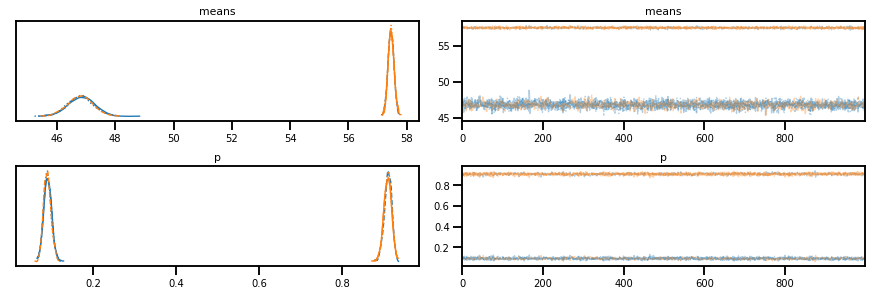

In [6]:
varnames = ['means', 'p']
az.plot_trace(trace_mg, varnames)

In [7]:
az.summary(trace_mg, varnames)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
means[0]  49.483  4.620  46.159   57.615      2.294    1.757       4.0   
means[1]  54.797  4.623  46.488   57.708      2.300    1.761       4.0   
p[0]       0.295  0.355   0.074    0.920      0.177    0.135       4.0   
p[1]       0.705  0.355   0.080    0.926      0.177    0.135       4.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
means[0]     4.0       7.0      28.0   1.53  
means[1]     4.0       7.0      30.0   1.53  
p[0]         4.0       7.0      33.0   1.53  
p[1]         4.0       7.0      33.0   1.53

Here we have a problem of parameter non-identifiability. The reason for this is that the labeling of each group doesn't really matter, and that is a problem for the model. We want an ordering of our variables. This can be done using pm.potential():

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.


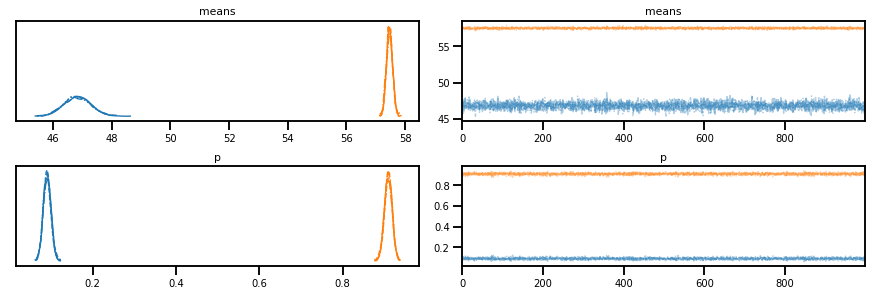

In [8]:
clusters = 2
with pm.Model() as model_mgp:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=np.array([.9, 1]) * cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    order_means = pm.Potential('order_means', tt.switch(means[1]-means[0] < 0, -np.inf, 0))
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    trace_mgp = pm.sample(1000, random_seed=123)
    varnames = ['means', 'p']
    az.plot_trace(trace_mgp, varnames)

In [9]:
az.summary(trace_mgp)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
means[0]  46.829  0.447  46.026   47.683      0.008    0.005    3347.0   
means[1]  57.465  0.101  57.282   57.655      0.002    0.001    4399.0   
p[0]       0.091  0.009   0.072    0.107      0.000    0.000    3462.0   
p[1]       0.909  0.009   0.893    0.928      0.000    0.000    3462.0   
sd         3.650  0.075   3.510    3.792      0.001    0.001    4592.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
means[0]  3345.0    3359.0    3252.0    1.0  
means[1]  4398.0    4400.0    3094.0    1.0  
p[0]      3430.0    3473.0    3161.0    1.0  
p[1]      3462.0    3473.0    3161.0    1.0  
sd        4576.0    4639.0    2599.0    1.0

We can contrain our variables to always have some data associated with the group by:

p_min = pm.Potential('p_min', tt.switch(tt.min(p) < min_p, -np.inf, 0))

Here, you can set min_p to some arbitrary, but reasonable value, such as 0.1 or 0.01

In [10]:
clusters = [3, 4, 5, 6]
models = []
traces = []
for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(cluster))
        means = pm.Normal('means',
        mu=np.linspace(cs_exp.min(), cs_exp.max(),
        cluster),
        sd=10, shape=cluster,
        transform=pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sd=10)
        y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
        trace = pm.sample(1000, tune=2000, random_seed=123)
        traces.append(trace)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 123 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 135 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 221 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6983898857285481, but should be close to 0.8. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6818030146851645, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 324 seconds.
The acceptance probability does not match the target. It is 0.930740068353634, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8814675126692477, but should be close to 0.8. Try to increase the number of tuning steps.
There were 639 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3783858621543892, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


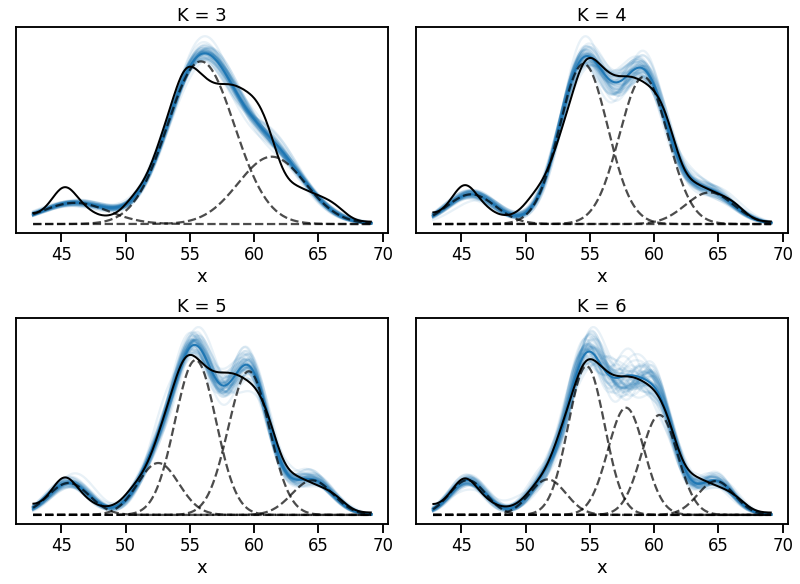

In [11]:
_, ax = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)
ax = np.ravel(ax)
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
for idx, trace_x in enumerate(traces):
    x_ = np.array([x] * clusters[idx]).T
    for i in range(50):
        i_ = np.random.randint(0, len(trace_x))
        means_y = trace_x['means'][i_]
        p_y = trace_x['p'][i_]
        sd = trace_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', alpha=0.1)
    means_y = trace_x['means'].mean(0)
    p_y = trace_x['p'].mean(0)
    sd = trace_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y, 'k--', alpha=0.7)
    az.plot_kde(cs_exp, plot_kwargs={'linewidth':2, 'color':'k'},
                ax=ax[idx])
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


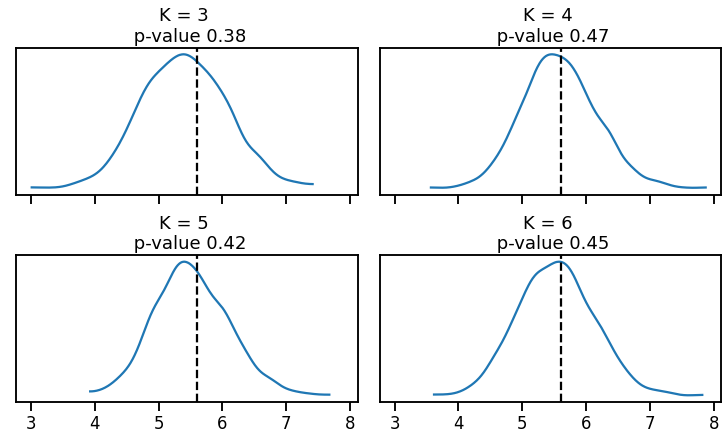

In [13]:
ppc_mm = [pm.sample_posterior_predictive(traces[i], 1000, models[i])
for i in range(4)]
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True,
constrained_layout=True)
ax = np.ravel(ax)
def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))
T_obs = iqr(cs_exp)
for idx, d_sim in enumerate(ppc_mm):
    T_sim = iqr(d_sim['y'][:100].T, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {clusters[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])

In [14]:
comp = az.compare(dict(zip(clusters, traces)), method='BB-pseudo-BMA')
comp

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank          loo      p_loo      d_loo        weight         se       dse  \
6     0 -5124.148373  11.954918   0.000000  9.513393e-01  30.817078  0.000000   
5     1 -5129.218662   9.834265   5.070289  4.776838e-02  30.212912  2.576271   
4     2 -5139.615192   7.630437  15.466819  8.922736e-04  29.686396  5.007595   
3     3 -5178.371447   5.853342  54.223074  4.155380e-14  29.748393  9.406007   

   warning loo_scale  
6    False       log  
5    False       log  
4    False       log  
3    False       log

KeyError: 0

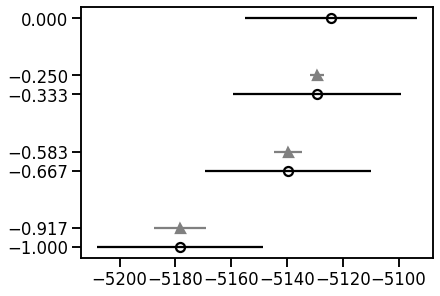

In [16]:
az.plot_compare(comp)

In [20]:
def stick_breaking_truncated(α, H, K):
    """
    Truncated stick-breaking process view of a DP
    Parameters
    ----------
    α : float
    concentration parameter
    H : scipy distribution
    Base distribution
    K : int
    number of components
    Returns
    -------
    locs : array
    locations
    w : array
    probabilities
    """
    βs = stats.beta.rvs(1, α, size=K)
    w = np.empty(K)
    w = βs * np.concatenate(([1.], np.cumprod(1 - βs[:-1])))
    locs = H.rvs(size=K)
    return locs, w

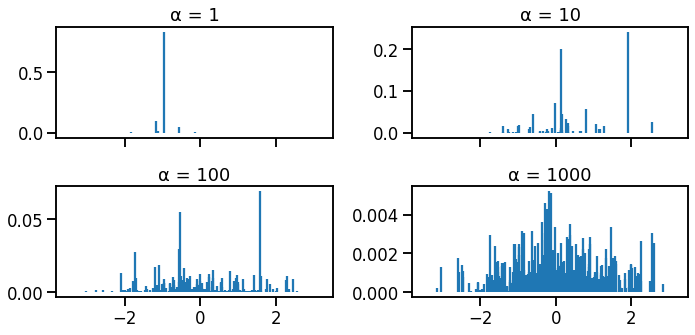

In [21]:
# Parameters DP
K = 500
H = stats.norm
alphas = [1, 10, 100, 1000]
_, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
ax = np.ravel(ax)
for idx, α in enumerate(alphas):
    locs, w = stick_breaking_truncated(α, H, K)
    ax[idx].vlines(locs, 0, w, color='C0')
    ax[idx].set_title('α = {}'.format(α))
plt.tight_layout()

([], [])

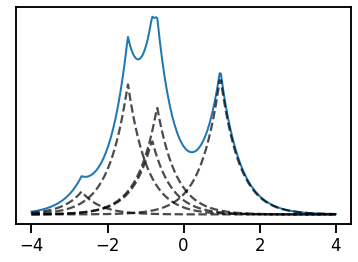

In [22]:
α = 10
H = stats.norm
K = 5
x = np.linspace(-4, 4, 250)
x_ = np.array([x] * K).T
locs, w = stick_breaking_truncated(α, H, K)
dist = stats.laplace(locs, 0.5)
plt.plot(x, np.sum(dist.pdf(x_) * w, 1), 'C0', lw=2)
plt.plot(x, dist.pdf(x_) * w, 'k--', alpha=0.7)
plt.yticks([])

In [23]:
N = cs_exp.shape[0]
K = 20
def stick_breaking(α):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.],
    tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

NOTE: Theano goes absolutely crazy if you have more than one jupyter notebook at the same time. 

In [25]:
with pm.Model() as model:
    α = pm.Gamma('α', 1., 1.)
    w = pm.Deterministic('w', stick_breaking(α))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=K)
    sd = pm.HalfNormal('sd', sd=10, shape=K)
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=cs_exp.values)
    trace = pm.sample(1000, tune=2000, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, β, α]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1532 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8393401472139875, but should be close to 0.9. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7988583437794061, but should be close to 0.9. Try to increase the number of tuning steps.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

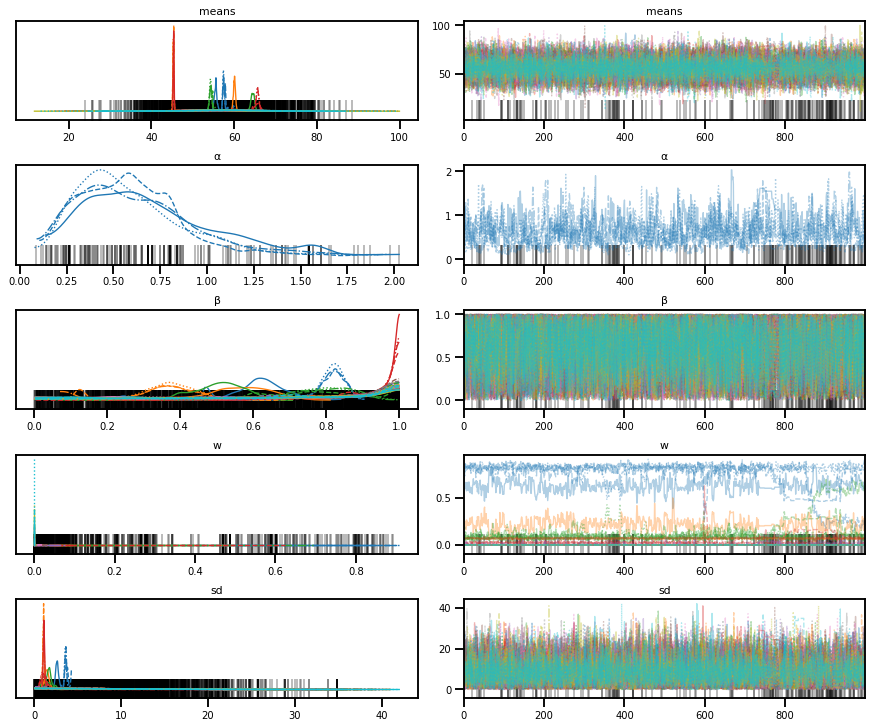

In [26]:
az.plot_trace(trace)

Notice that we have set K to be 20. This is the upper limit so to speak of our components. We want to check that the number of components is enough, so that we don't introduce bias in the model. This is done by having only neglectible weights in the last couple of components. 

Text(0, 0.5, 'Average weight')

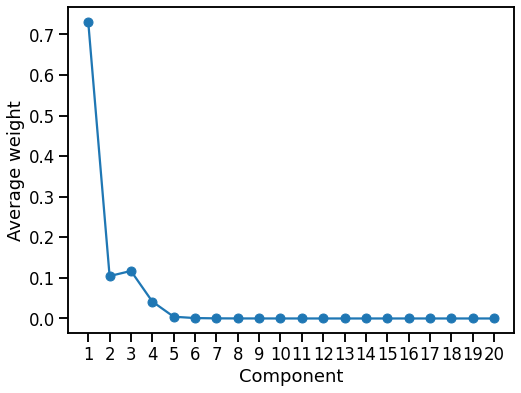

In [27]:
plt.figure(figsize=(8, 6))
plot_w = np.arange(K)
plt.plot(plot_w, trace['w'].mean(0), 'o-')
plt.xticks(plot_w, plot_w+1)
plt.xlabel('Component')
plt.ylabel('Average weight')

([], [])

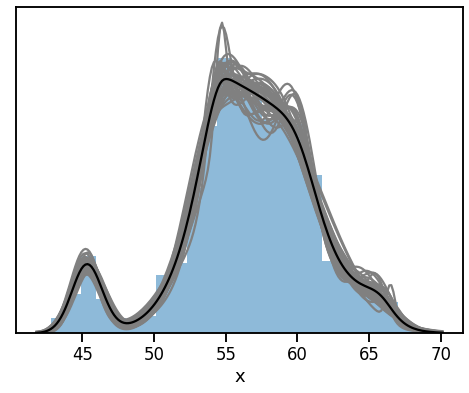

In [28]:
x_plot = np.linspace(cs.exp.min()-1, cs.exp.max()+1, 200)
post_pdf_contribs = stats.norm.pdf(np.atleast_3d(x_plot),
trace['means'][:, np.newaxis, :],
trace['sd'][:, np.newaxis, :])
post_pdfs = (trace['w'][:, np.newaxis, :] *
post_pdf_contribs).sum(axis=-1)
plt.figure(figsize=(8, 6))
plt.hist(cs_exp.values, bins=25, density=True, alpha=0.5)
plt.plot(x_plot, post_pdfs[::100].T, c='0.5')
plt.plot(x_plot, post_pdfs.mean(axis=0), c='k')
plt.xlabel('x')
plt.yticks([])

## Exercises:
### Exercise 1: Get Good at Generating Gaussians
Generate synthetic from a mixture of three Gaussians. Check the accompanying
Jupyter Notebook for this chapter for an example on how to do this. Fit a finite
Gaussian mixture model with 2, 3, or 4 components.

In [29]:
## START BY SIMULATING DATA:
clusters = 3

n_cluster = [90, 50, 75]
n_total = sum(n_cluster)

means = [9, 21, 35]
std_devs = [2, 2, 2]

mix = np.random.normal(np.repeat(means, n_cluster), np.repeat(std_devs, n_cluster))

<AxesSubplot:ylabel='Density'>

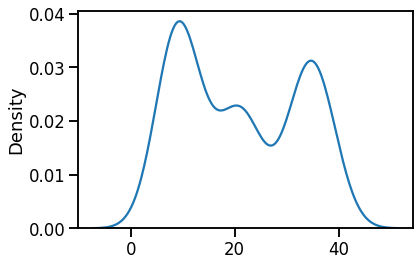

In [31]:
sns.kdeplot(np.array(mix))

In [44]:
with pm.Model() as GausMix:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    p_min = pm.Potential('p_min', tt.switch(tt.min(p) < 0.01, -np.inf, 0))
    
    ### HYPER PRIORS ###
    prior_μ = pm.HalfNormal("prior_μ", 20)
    prior_σ = pm.HalfNormal("prior_σ", 2)
    
    ### PRIORS ###
    μ = pm.Normal('μ', mu=prior_μ, sd=prior_σ, shape=clusters)
    sd = pm.HalfCauchy('sd', 2)
    
    ### LIKELIHOOD ###
    y = pm.NormalMixture('y', w=p, mu=μ, sd=sd, observed=mix)
    
    trace_mg = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, μ, prior_σ, prior_μ, p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 74 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>],
       [<AxesSubplot:title={'center':'prior_μ'}>,
        <AxesSubplot:title={'center':'prior_μ'}>],
       [<AxesSubplot:title={'center':'prior_σ'}>,
        <AxesSubplot:title={'center':'prior_σ'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

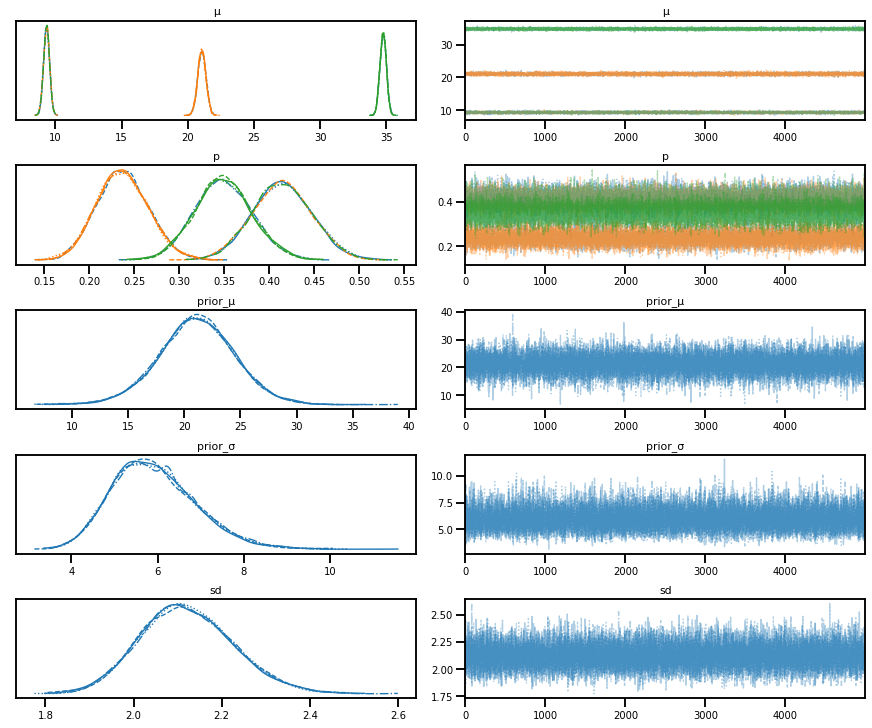

In [45]:
az.plot_trace(trace_mg)

Getting the problem that the ordering is not fixed. Tried introducing the stuff, but nothing happens. Get back!

In [46]:
traces = []
models = []
for clusters in [2, 3, 4]:

    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(clusters))
        p_min = pm.Potential('p_min', tt.switch(tt.min(p) < 0.01, -np.inf, 0))

        ### HYPER PRIORS ###
        prior_μ = pm.HalfNormal("prior_μ", 20)
        prior_σ = pm.HalfNormal("prior_σ", 2)

        ### PRIORS ###
        μ = pm.Normal('μ', mu=prior_μ, sd=prior_σ, shape=clusters)
        sd = pm.HalfCauchy('sd', 2)

        ### LIKELIHOOD ###
        y = pm.NormalMixture('y', w=p, mu=μ, sd=sd, observed=mix)

        trace_mg = pm.sample(5000)
        traces.append(trace_mg)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, μ, prior_σ, prior_μ, p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 83 seconds.
The acceptance probability does not match the target. It is 0.8889134691711048, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, μ, prior_σ, prior_μ, p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, μ, prior_σ, prior_μ, p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 121 seconds.
There were 1080 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1328 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6600778831409483, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1596 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6352303513719871, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2055 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2573009364403139, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The e

## Exercise 2: Waiting for WAIC
Use WAIC and LOO to compare the results from exercise 1

In [47]:
comp = az.compare(dict(zip([2, 3, 4], traces)), method='BB-pseudo-BMA')
comp

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:913: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


rank         loo     p_loo      d_loo        weight        se       dse  \
3     0 -699.695792  5.750556   0.000000  6.537974e-01  9.437363  0.000000   
4     1 -700.347944  6.329571   0.652152  3.462026e-01  5.681223  0.319833   
2     2 -786.046299  3.523112  86.350507  2.477809e-29  9.615128  9.492689   

   warning loo_scale  
3    False       log  
4    False       log  
2    False       log

In [51]:
comp = az.compare(dict(zip([2, 3, 4], traces)), method='stacking', ic = "waic")
comp

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank        waic    p_waic     d_waic        weight        se       dse  \
3     0 -699.693473  5.748237   0.000000  1.000000e+00  9.732967  0.000000   
4     1 -700.342050  6.323677   0.648577  0.000000e+00  9.552410  0.321035   
2     2 -786.045375  3.522188  86.351902  5.995093e-11  5.601467  9.492352   

   warning waic_scale  
3    False        log  
4    False        log  
2    False        log

KeyError: 0

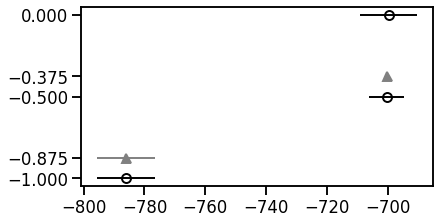

In [48]:
az.plot_compare(comp)

So... no idea whether or not I misunderstood everything here. Should probably return.

## Exercise 3: The Dread of All Students - run through notebooks

## NOTEBOOK 1: 

In [52]:
import arviz as az
import numpy as np
import pymc3 as pm
import seaborn as sns

from matplotlib import pyplot as plt

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.0


In [53]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [54]:
N = 1000

W = np.array([0.35, 0.4, 0.25])

MU = np.array([0.0, 2.0, 5.0])
SIGMA = np.array([0.5, 0.5, 1.0])

In [55]:
component = np.random.choice(MU.size, size=N, p=W)
x = np.random.normal(MU[component], SIGMA[component], size=N)

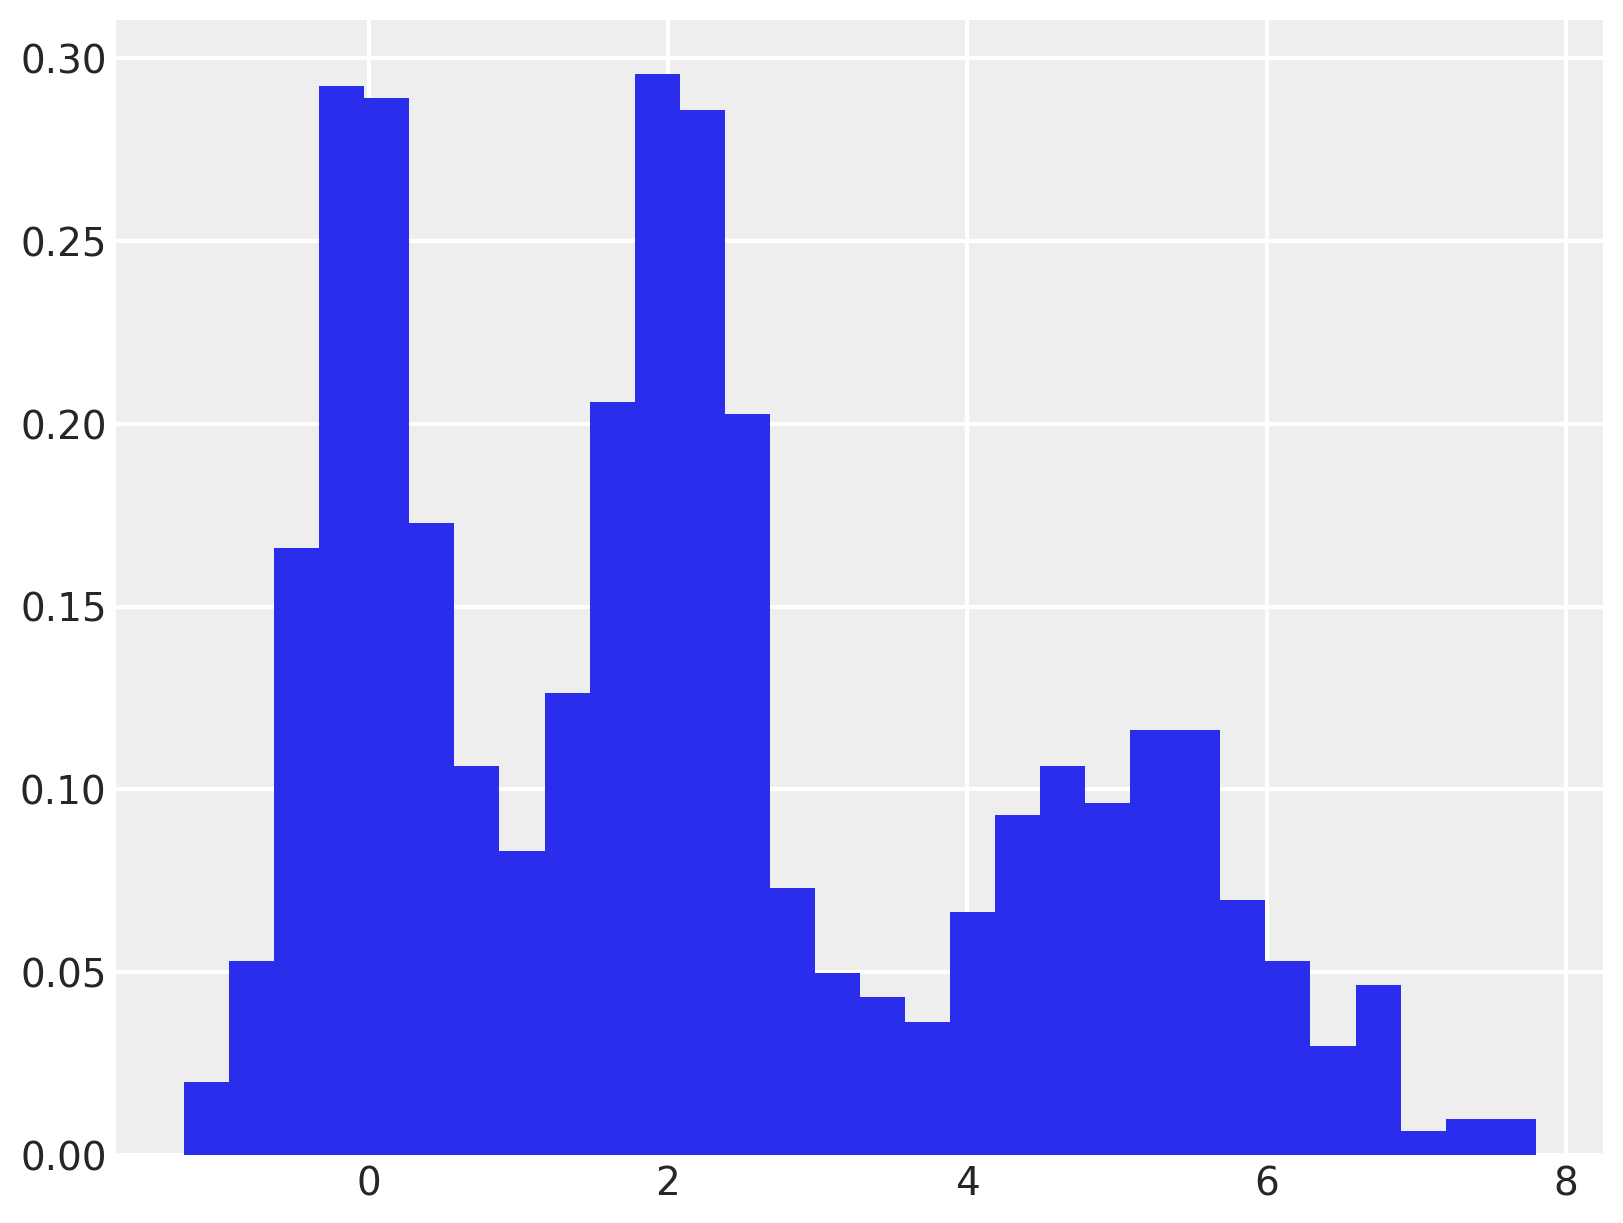

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=30, density=True, lw=0);

In [57]:
with pm.Model() as model:
    w = pm.Dirichlet("w", np.ones_like(W))

    mu = pm.Normal("mu", 0.0, 10.0, shape=W.size)
    tau = pm.Gamma("tau", 1.0, 1.0, shape=W.size)

    x_obs = pm.NormalMixture("x_obs", w, mu, tau=tau, observed=x)

with model:
    trace = pm.sample(5000, n_init=10000, tune=1000)

    # sample posterior predictive samples
    ppc_trace = pm.sample_posterior_predictive(trace, var_names=["x_obs"])

    # Get an arviz inference object
    idata_pymc3 = az.from_pymc3(trace, posterior_predictive=ppc_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu, w]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


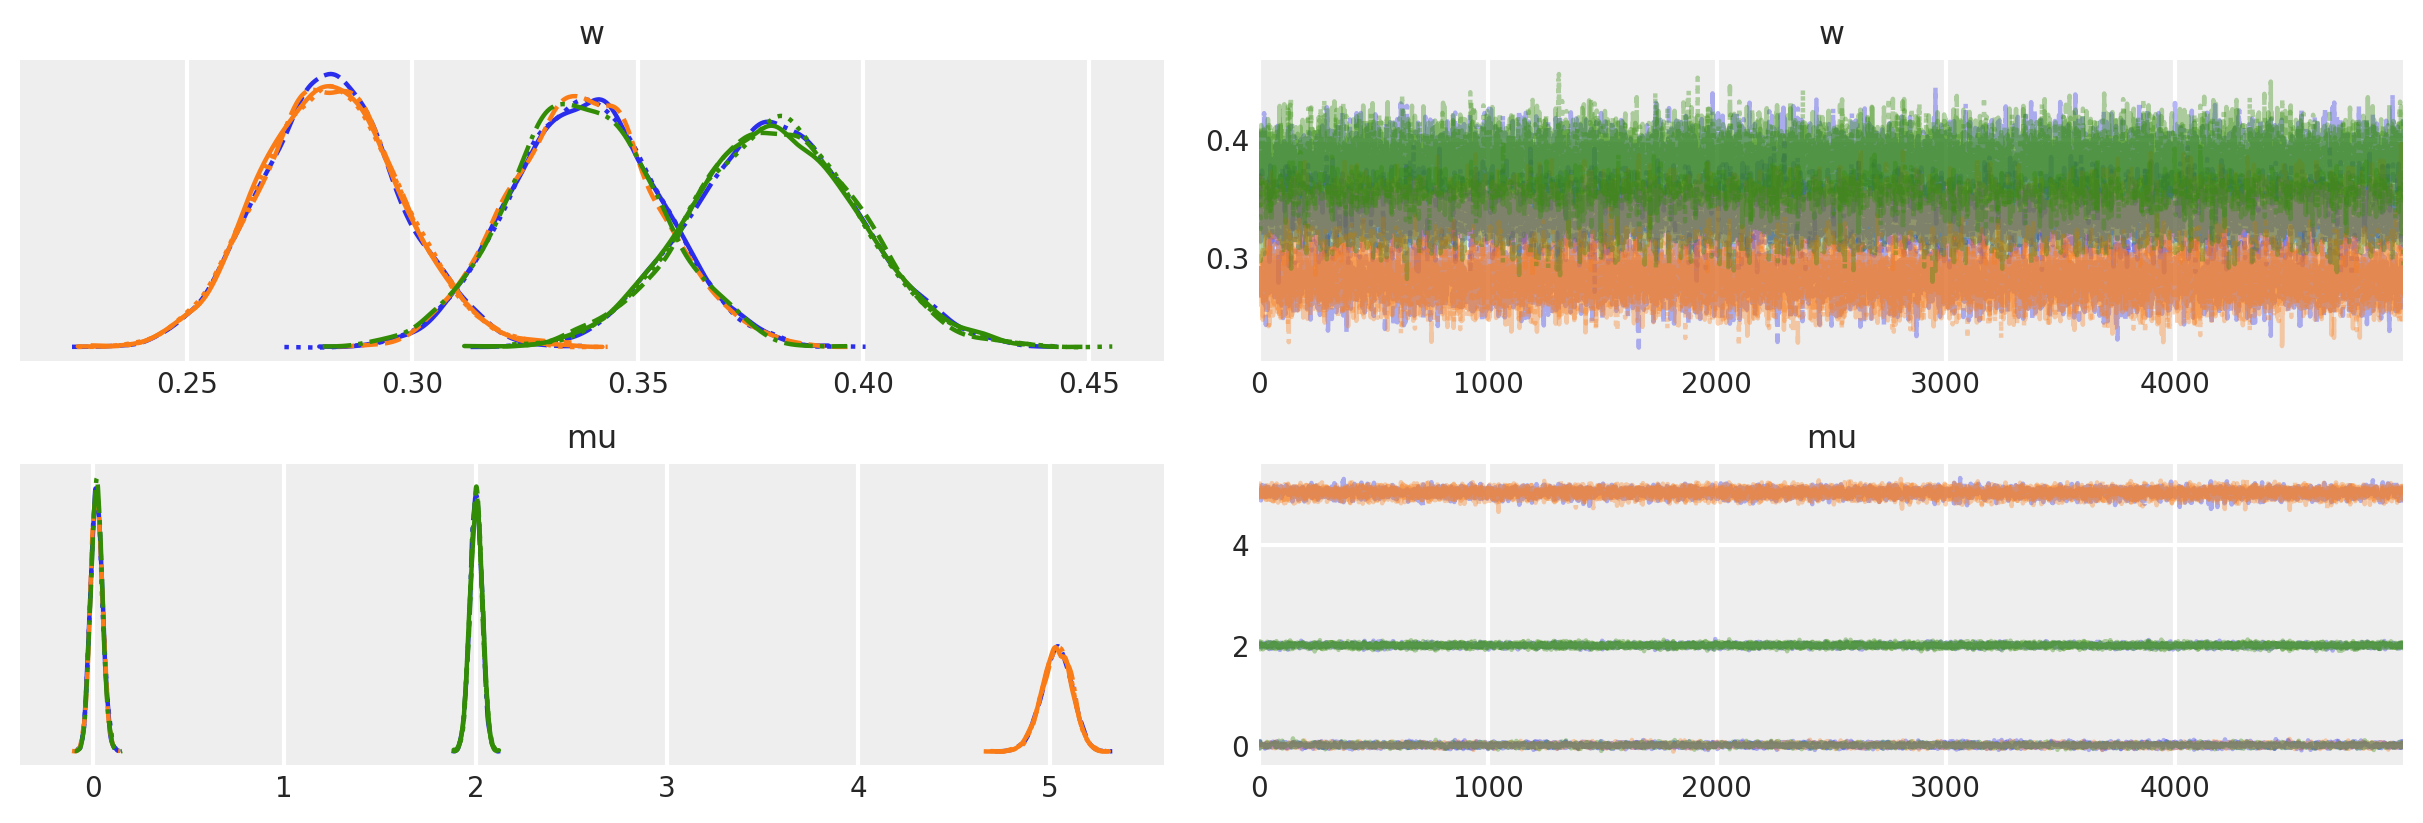

In [58]:
az.plot_trace(idata_pymc3, var_names=["w", "mu"]);

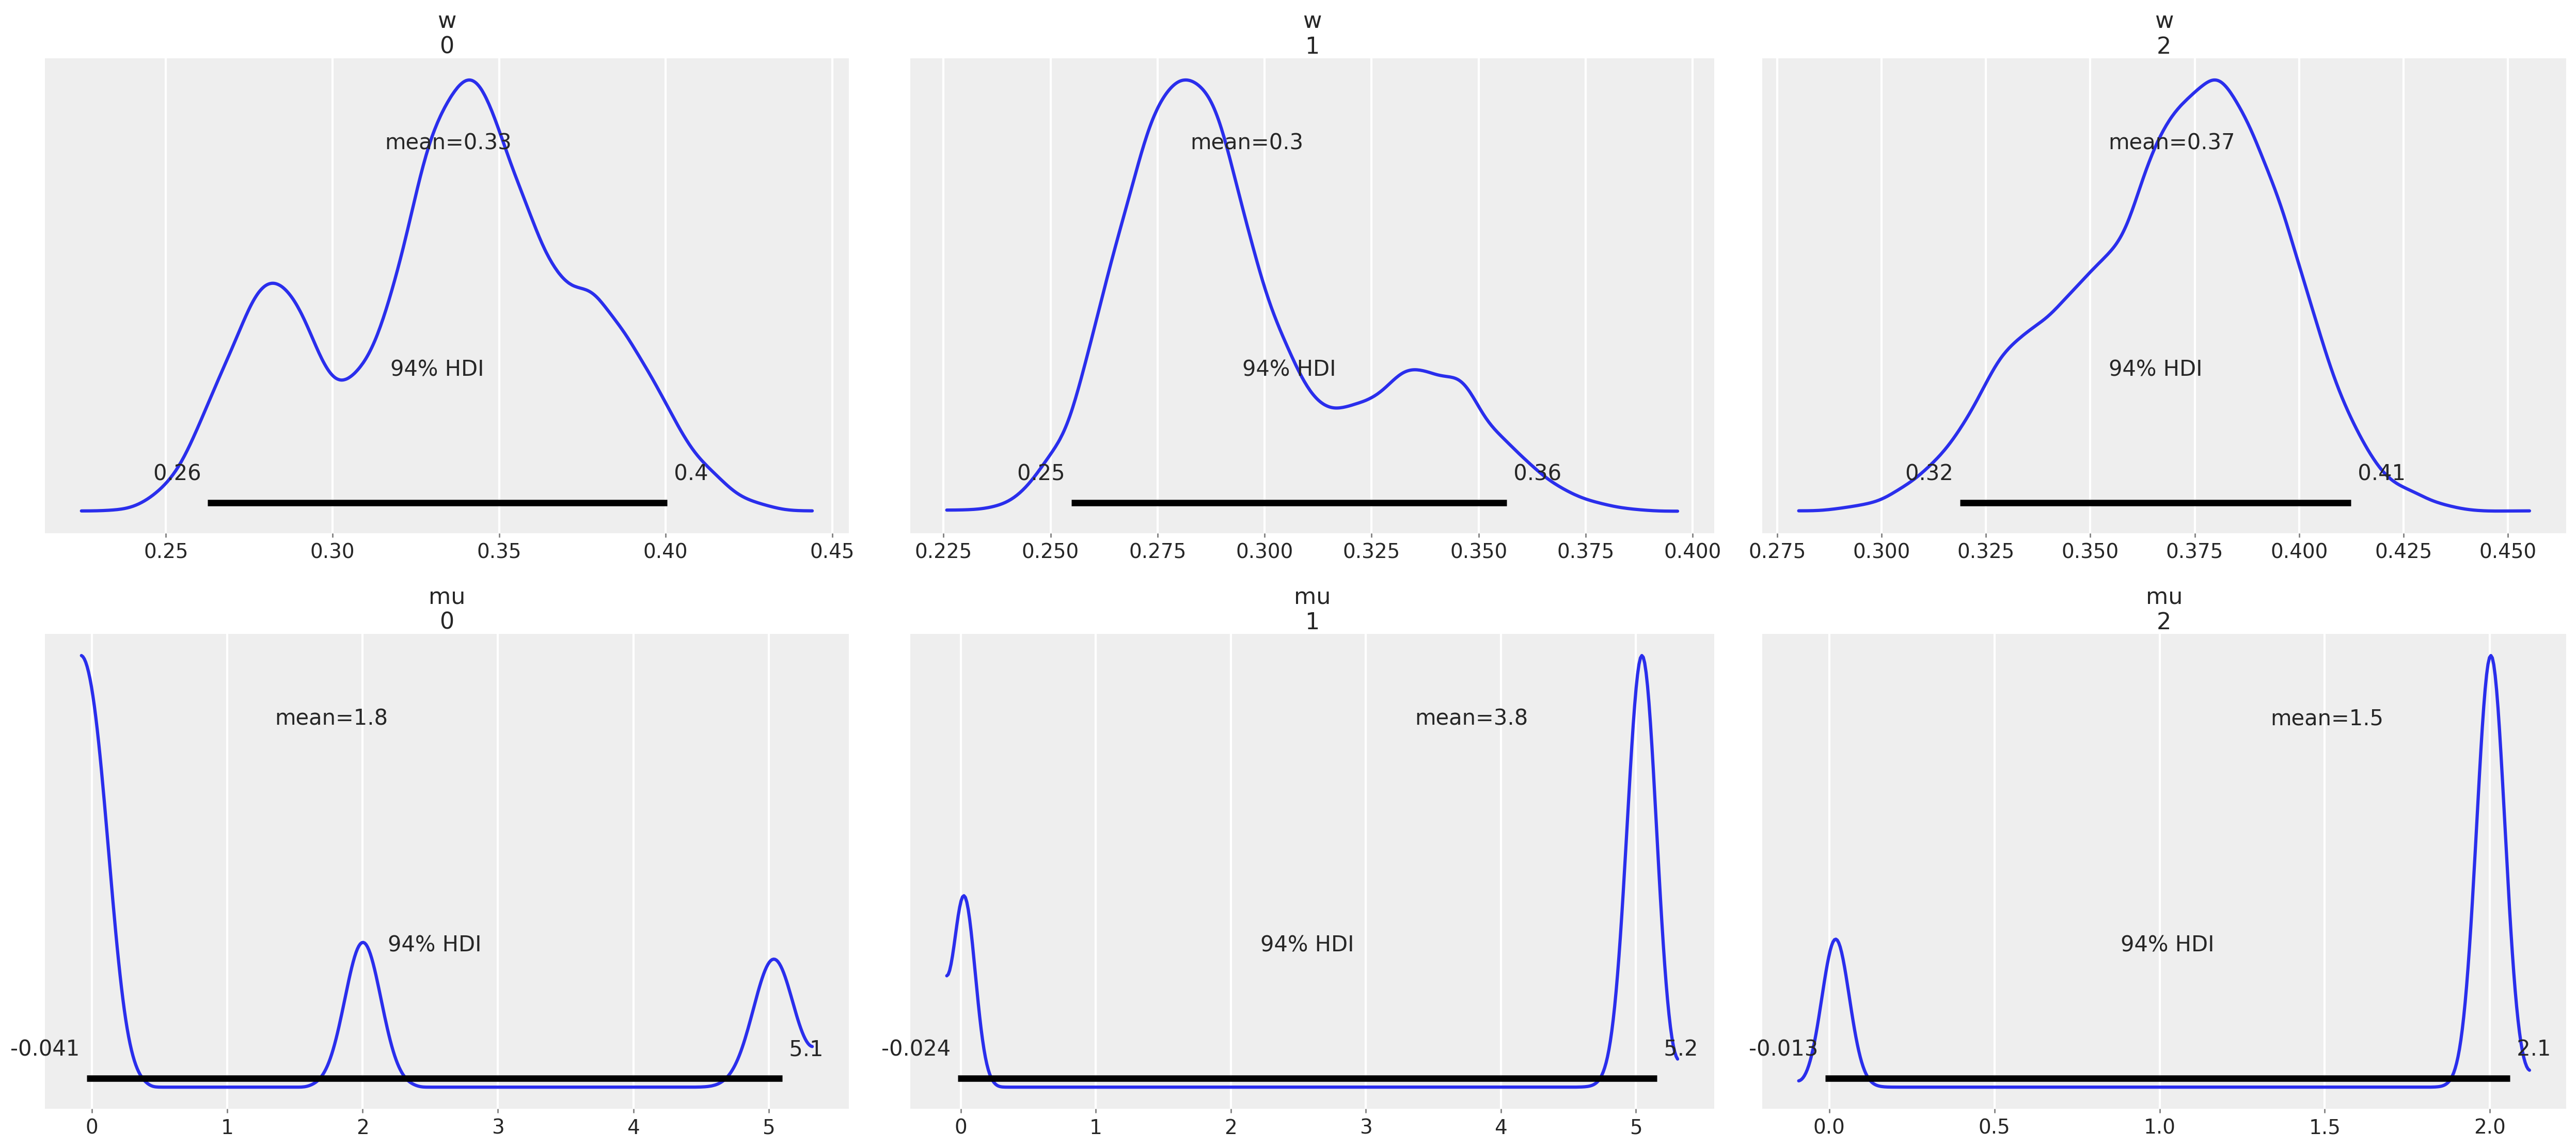

In [59]:
az.plot_posterior(idata_pymc3, var_names=["w", "mu"]);

<AxesSubplot:xlabel='x_obs'>

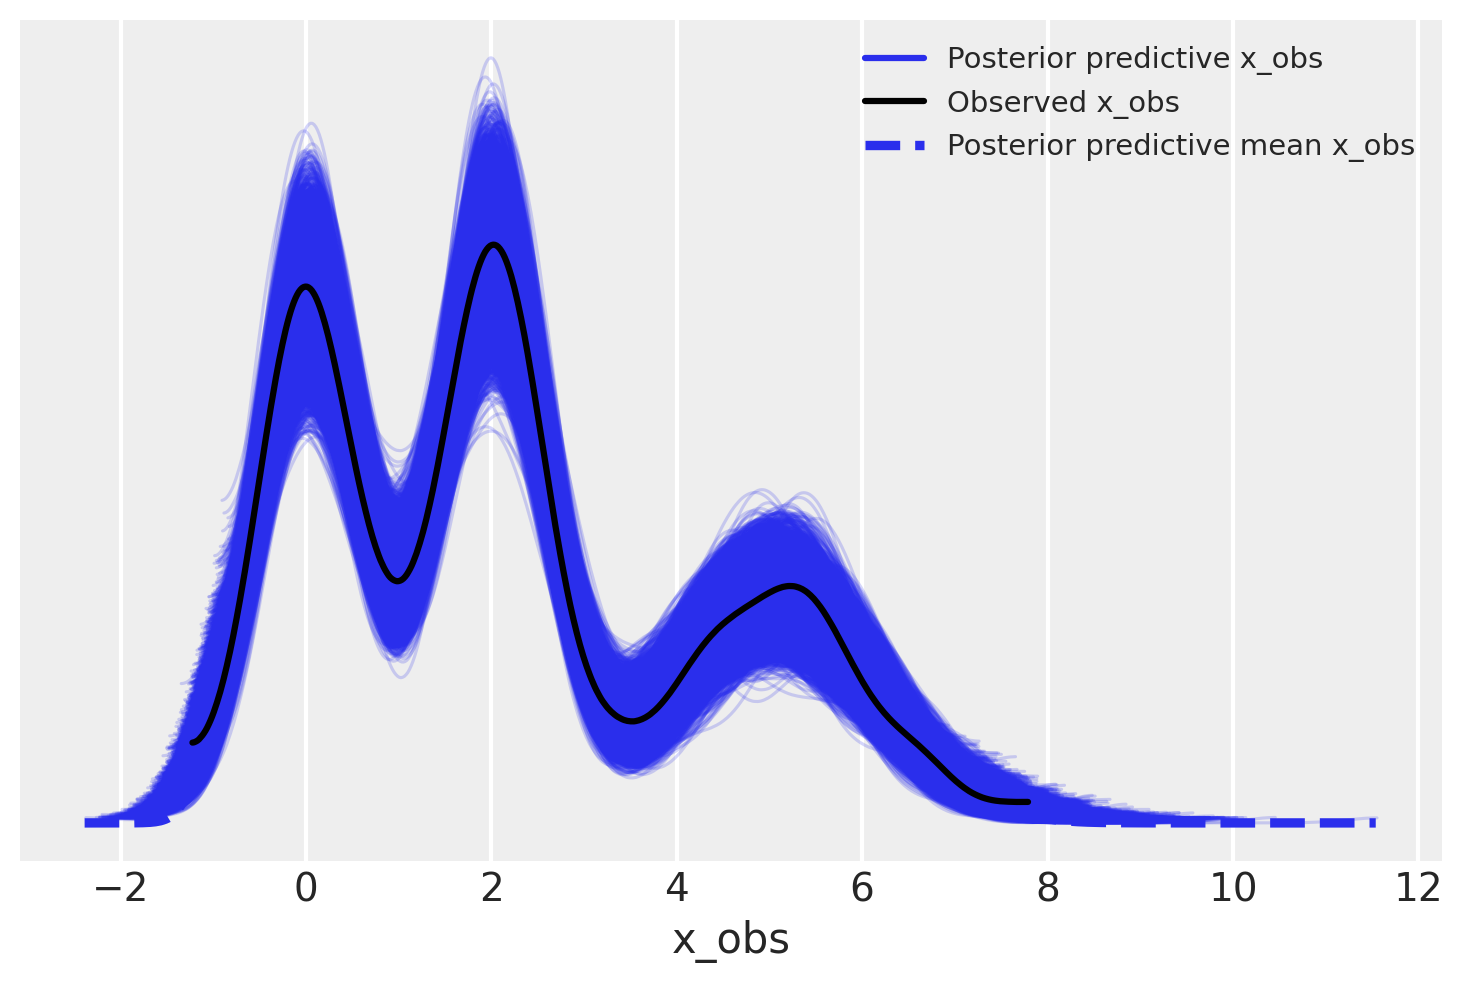

In [60]:
az.plot_ppc(idata_pymc3)

Uhhh note! By including the idata object, you can just run the damn shit into plot ppc - That's very nice.

In [61]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from IPython.display import HTML
from matplotlib import animation as ani
from matplotlib import pyplot as plt
from theano import shared
from theano import tensor as tt

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.0


In [62]:
%config InlineBackend.figure_format = 'retina'
plt.rc("animation", writer="ffmpeg")
blue, *_ = sns.color_palette()
az.style.use("arviz-darkgrid")
SEED = 972915  # from random.org; for reproducibility
np.random.seed(SEED)

In [89]:
DATA_URI = "http://www.stat.cmu.edu/~larry/all-of-nonpar/=data/lidar.dat"


def standardize(x):
    return (x - x.mean()) / x.std()

df = pd.read_csv(DATA_URI, sep="\n", engine="python")
#.assign(
#    std_range=lambda df: standardize(df.range), std_logratio=lambda df: standardize(df.logratio)
#)

In [104]:
df["range"] = df["range logratio"].apply(lambda x: int(x[0:3]))

In [102]:
df["logratio"] = df["range logratio"].apply(lambda x: float(x[5:]))

In [106]:
df = df.assign(std_range=lambda df: standardize(df.range), std_logratio=lambda df: standardize(df.logratio))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


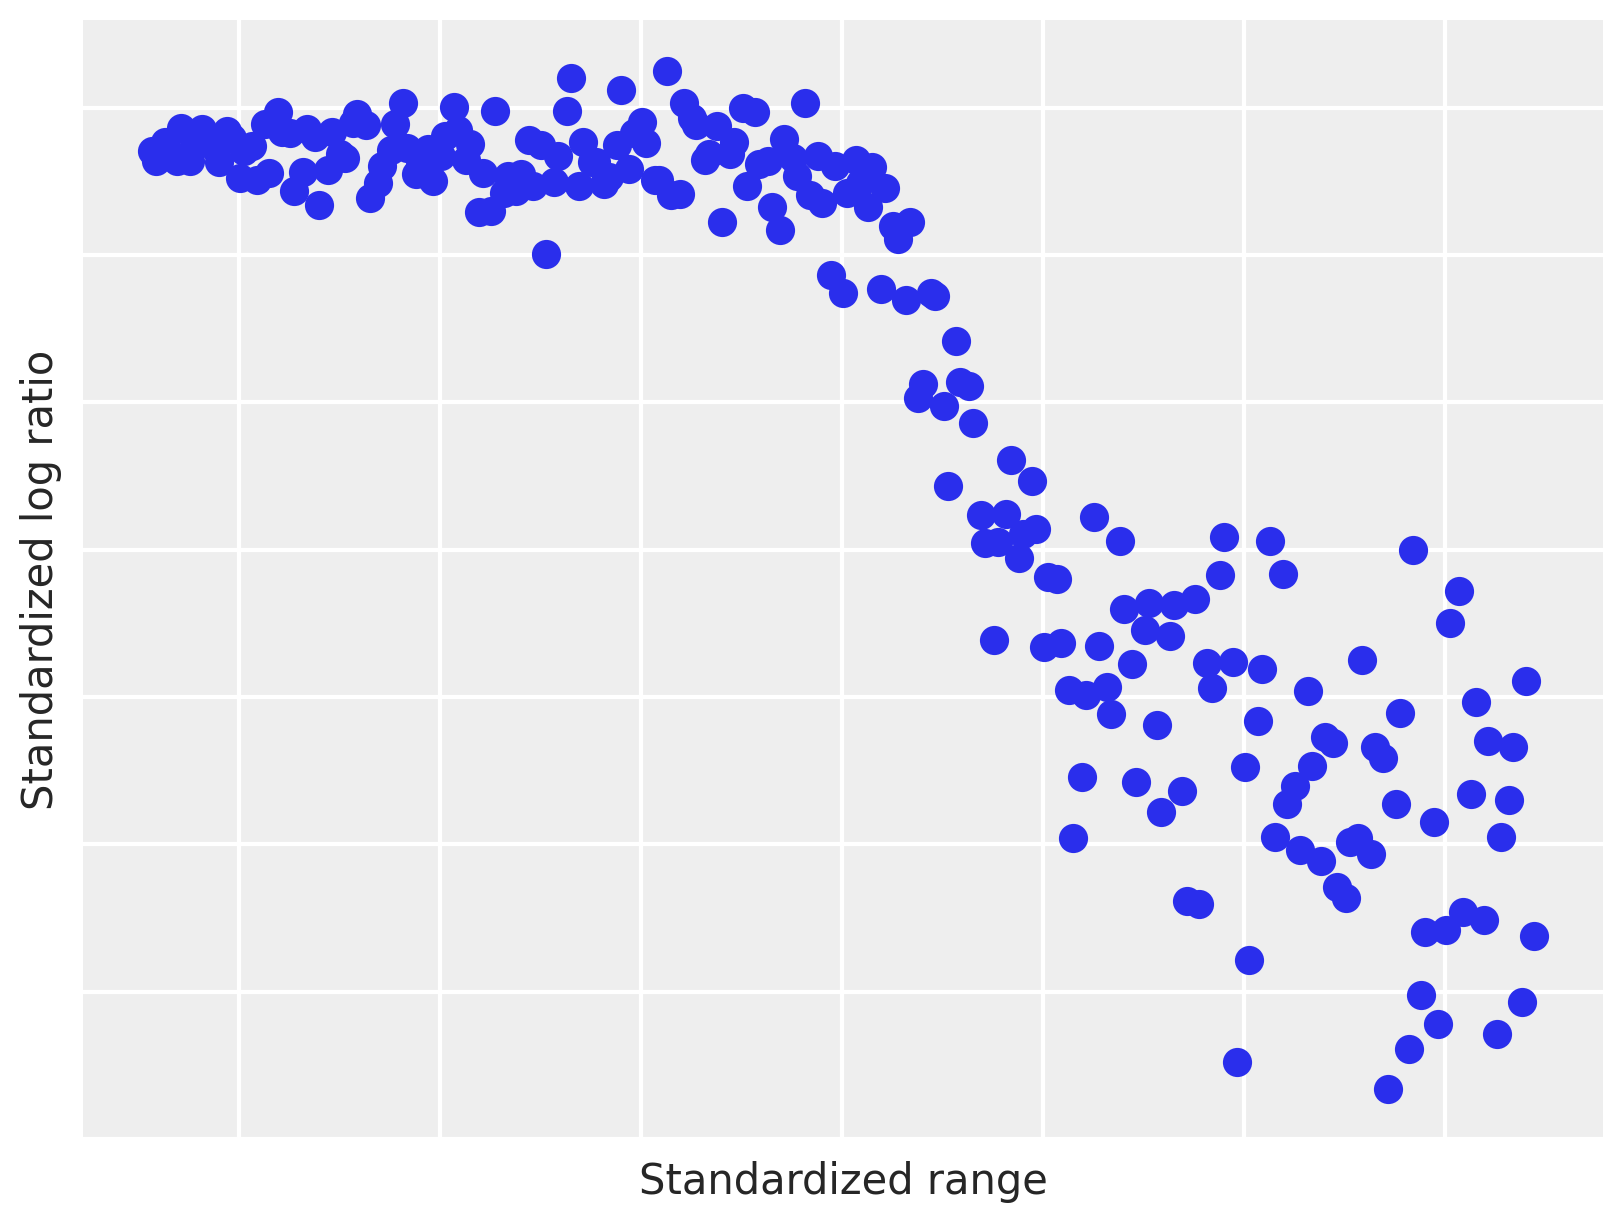

In [107]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df.std_range, df.std_logratio, c=blue)

ax.set_xticklabels([])
ax.set_xlabel("Standardized range")

ax.set_yticklabels([])
ax.set_ylabel("Standardized log ratio");

In [108]:
fig, (scatter_ax, hist_ax) = plt.subplots(ncols=2, figsize=(16, 6))

scatter_ax.scatter(df.std_range, df.std_logratio, c=blue, zorder=2)

scatter_ax.set_xticklabels([])
scatter_ax.set_xlabel("Standardized range")

scatter_ax.set_yticklabels([])
scatter_ax.set_ylabel("Standardized log ratio")

bins = np.linspace(df.std_range.min(), df.std_range.max(), 25)

hist_ax.hist(df.std_logratio, bins=bins, color="k", lw=0, alpha=0.25, label="All data")

hist_ax.set_xticklabels([])
hist_ax.set_xlabel("Standardized log ratio")

hist_ax.set_yticklabels([])
hist_ax.set_ylabel("Frequency")

hist_ax.legend(loc=2)

endpoints = np.linspace(1.05 * df.std_range.min(), 1.05 * df.std_range.max(), 15)

frame_artists = []

for low, high in zip(endpoints[:-1], endpoints[2:]):
    interval = scatter_ax.axvspan(low, high, color="k", alpha=0.5, lw=0, zorder=1)
    *_, bars = hist_ax.hist(
        df[df.std_range.between(low, high)].std_logratio, bins=bins, color="k", lw=0, alpha=0.5
    )

    frame_artists.append((interval,) + tuple(bars))

animation = ani.ArtistAnimation(fig, frame_artists, interval=500, repeat_delay=3000, blit=True)
plt.close()
# prevent the intermediate figure from showing

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [109]:
HTML(animation.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [110]:
def norm_cdf(z):
    return 0.5 * (1 + tt.erf(z / np.sqrt(2)))


def stick_breaking(v):
    return v * tt.concatenate(
        [tt.ones_like(v[:, :1]), tt.extra_ops.cumprod(1 - v, axis=1)[:, :-1]], axis=1
    )

In [111]:
N, _ = df.shape
K = 20

std_range = df.std_range.values[:, np.newaxis]
std_logratio = df.std_logratio.values[:, np.newaxis]

x_lidar = shared(std_range, broadcastable=(False, True))

with pm.Model() as model:
    alpha = pm.Normal("alpha", 0.0, 5.0, shape=K)
    beta = pm.Normal("beta", 0.0, 5.0, shape=K)
    v = norm_cdf(alpha + beta * x_lidar)
    w = pm.Deterministic("w", stick_breaking(v))

In [112]:
with model:
    gamma = pm.Normal("gamma", 0.0, 10.0, shape=K)
    delta = pm.Normal("delta", 0.0, 10.0, shape=K)
    mu = pm.Deterministic("mu", gamma + delta * x_lidar)

In [113]:
with model:
    tau = pm.Gamma("tau", 1.0, 1.0, shape=K)
    obs = pm.NormalMixture("obs", w, mu, tau=tau, observed=std_logratio)

In [114]:
SAMPLES = 20000
BURN = 10000

with model:
    step = pm.Metropolis()
    trace = pm.sample(SAMPLES, step, chains=1, tune=BURN, random_seed=SEED)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>Metropolis: [delta]
>Metropolis: [gamma]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 1 chain for 10_000 tune and 20_000 draw iterations (10_000 + 20_000 draws total) took 247 seconds.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\data\base.py:169: UserWarning: More chains (20000) than draws (5). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


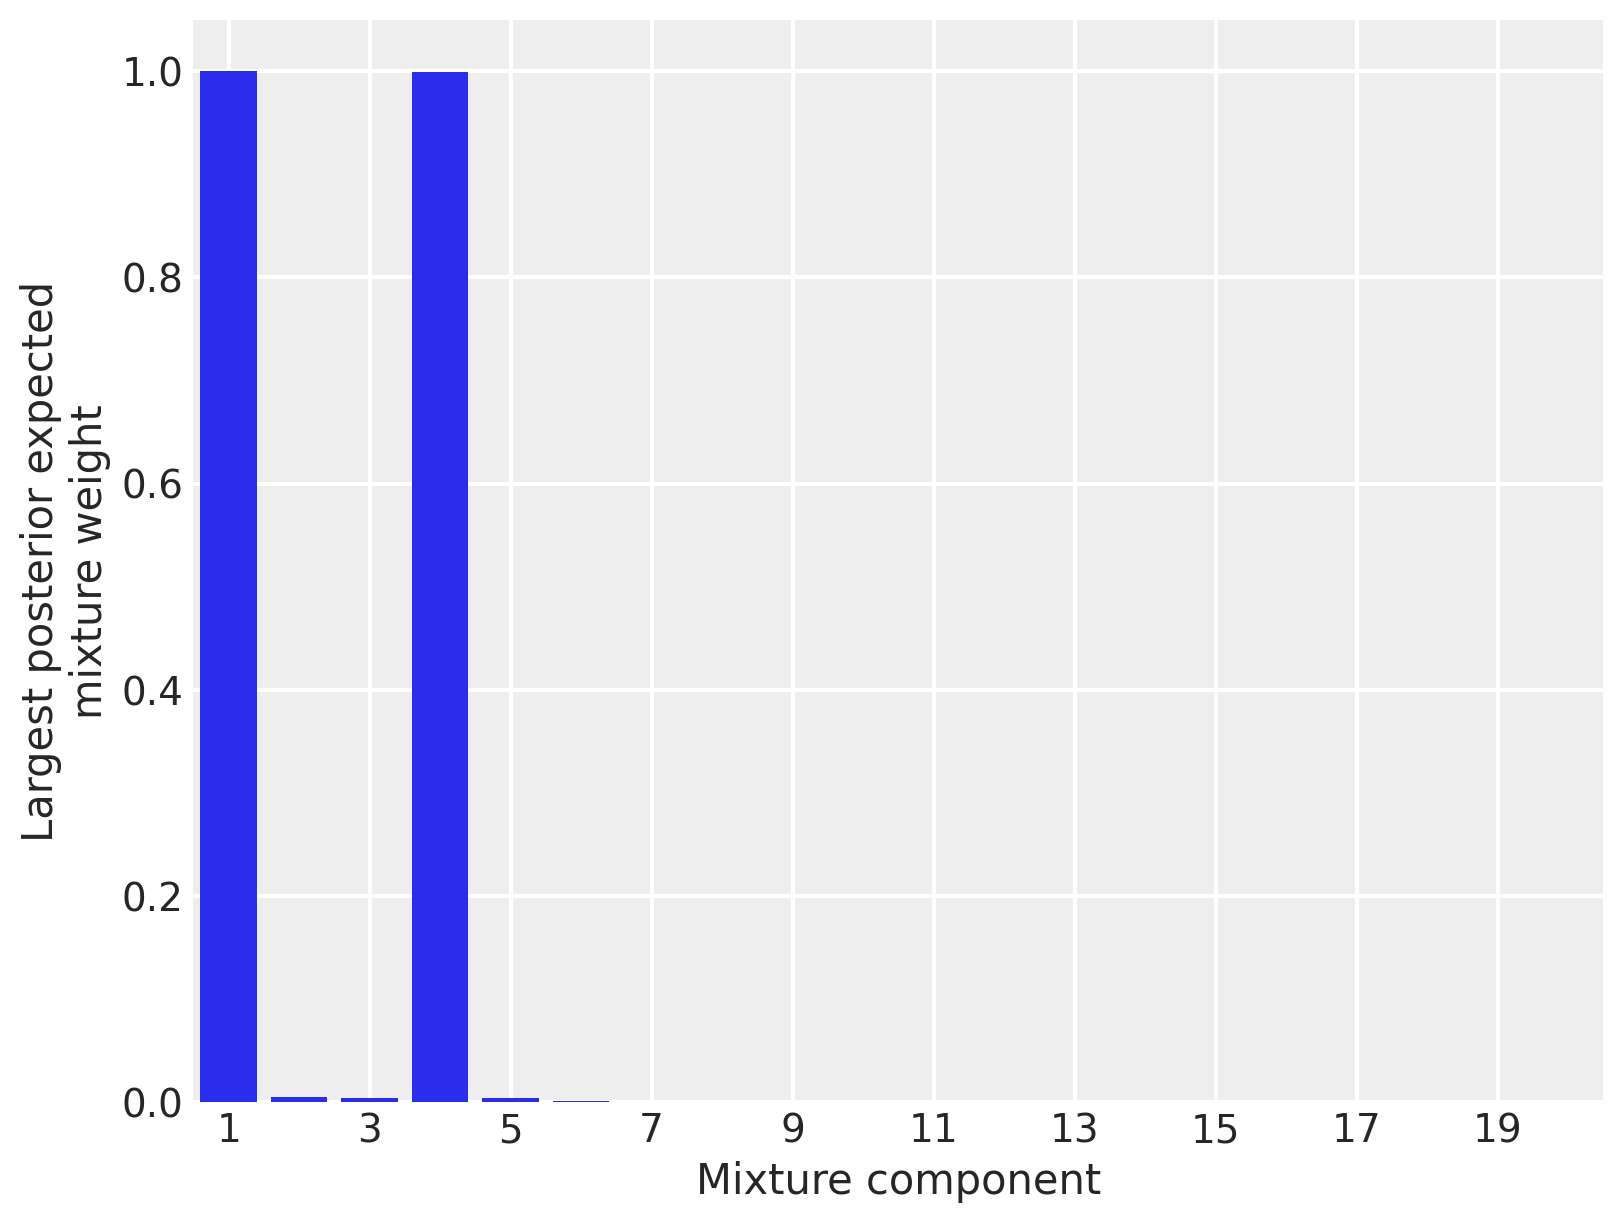

In [115]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(np.arange(K) + 1, trace["w"].mean(axis=0).max(axis=0))

ax.set_xlim(1 - 0.5, K + 0.5)
ax.set_xticks(np.arange(0, K, 2) + 1)
ax.set_xlabel("Mixture component")

ax.set_ylabel("Largest posterior expected\nmixture weight");

In [117]:
PP_SAMPLES = 100

lidar_pp_x = np.linspace(std_range.min() - 0.05, std_range.max() + 0.05, 100)
x_lidar.set_value(lidar_pp_x[:, np.newaxis])

with model:
    pp_trace = pm.sample_posterior_predictive(trace, PP_SAMPLES, random_seed=SEED)

In [120]:
pp_trace["obs"].flatten()

array([ 0.79166695,  0.9491082 ,  1.0103245 , ..., -1.67864835,
       -2.54604846, -1.54711135])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


ValueError: x and y must have same first dimension, but have shapes (100,) and (221, 100)

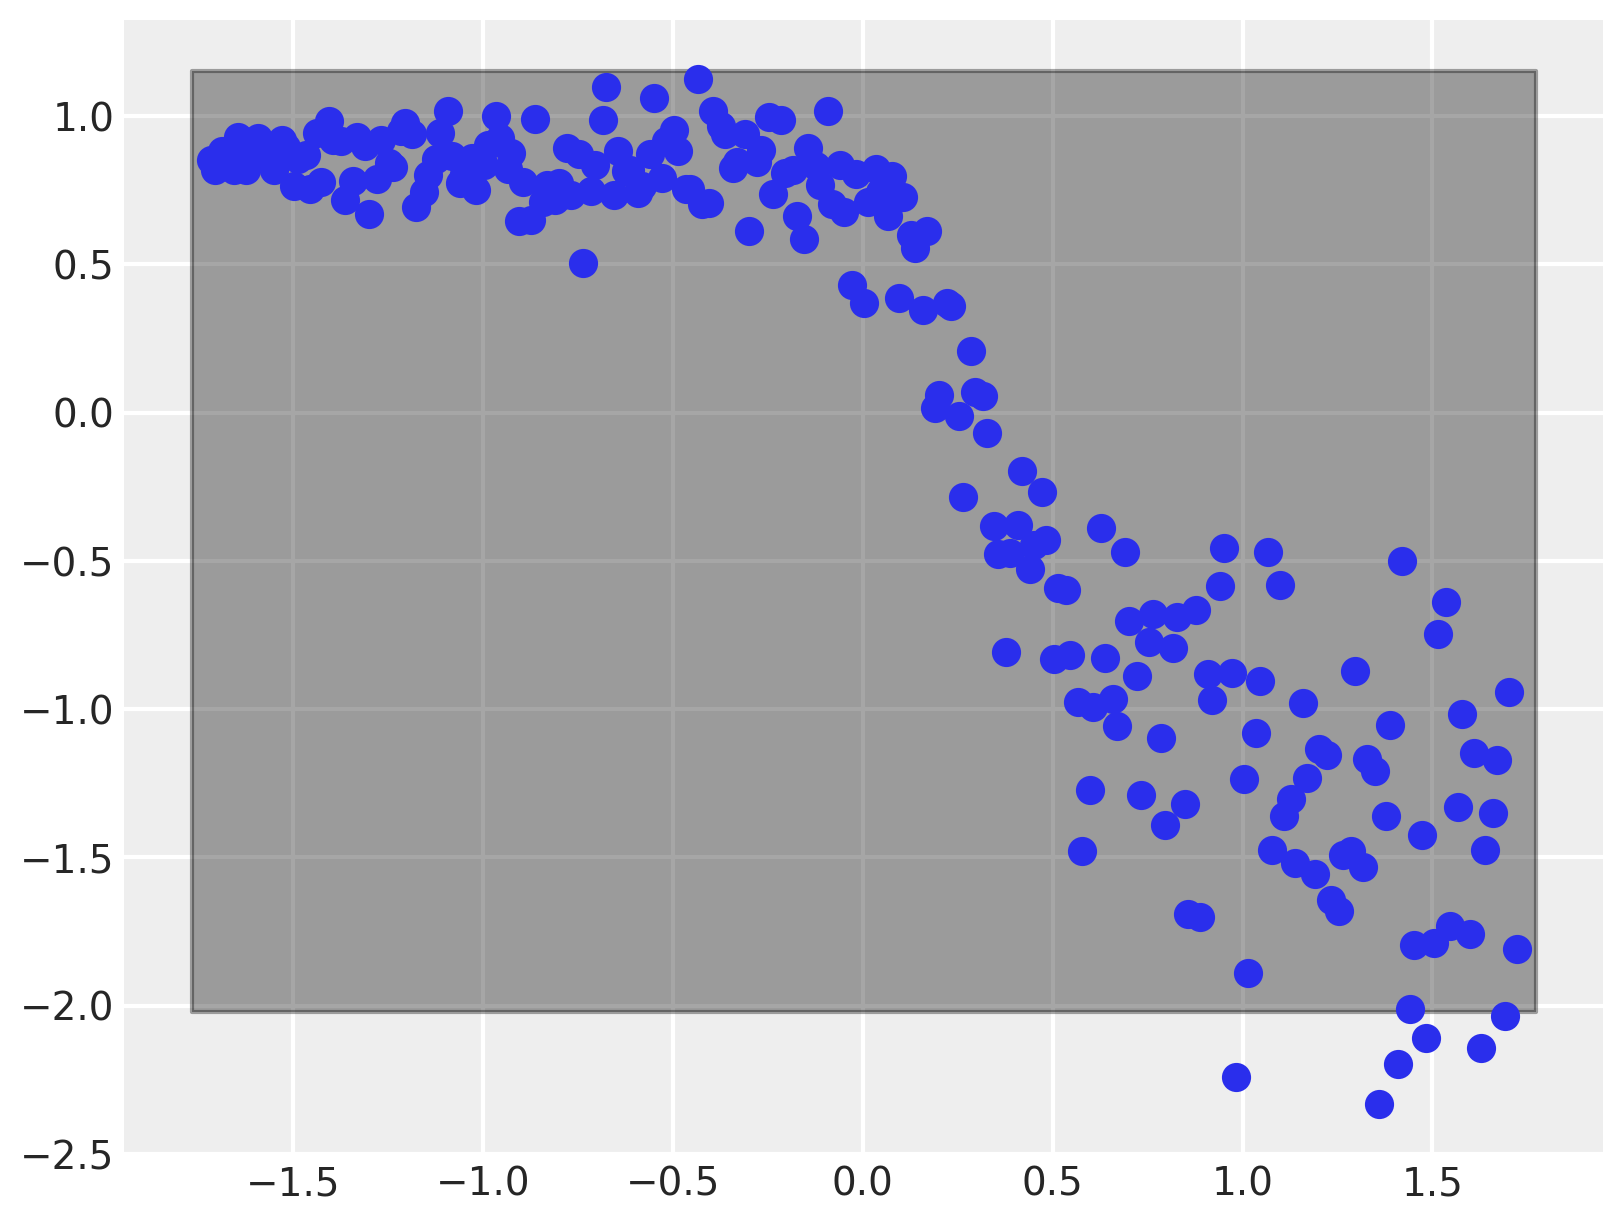

In [121]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df.std_range, df.std_logratio, c=blue, zorder=10, label=None)

low, high = np.percentile(pp_trace["obs"].flatten(), [2.5, 97.5], axis=0)
ax.fill_between(
    lidar_pp_x, low, high, color="k", alpha=0.35, zorder=5, label="95% posterior credible interval"
)

ax.plot(lidar_pp_x, pp_trace["obs"].mean(axis=0), c="k", zorder=6, label="Posterior expected value")

ax.set_xticklabels([])
ax.set_xlabel("Standardized range")

ax.set_yticklabels([])
ax.set_ylabel("Standardized log ratio")

ax.legend(loc=1)
ax.set_title("LIDAR Data");

We are really on a streak with these shitty notebooks:

### NEXT NOTEBOOK!

In [ ]:
%env THEANO_FLAGS=device=cpu,floatX=float32

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt

from pymc3 import (
    NUTS,
    DensityDist,
    Dirichlet,
    Metropolis,
    MvNormal,
    Normal,
    Slice,
    find_MAP,
    sample,
)
from pymc3.math import logsumexp
from theano.tensor.nlinalg import det

print(f"Running on PyMC3 v{pm.__version__}")

env: THEANO_FLAGS=device=cpu,floatX=float32
Running on PyMC3 v3.11.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

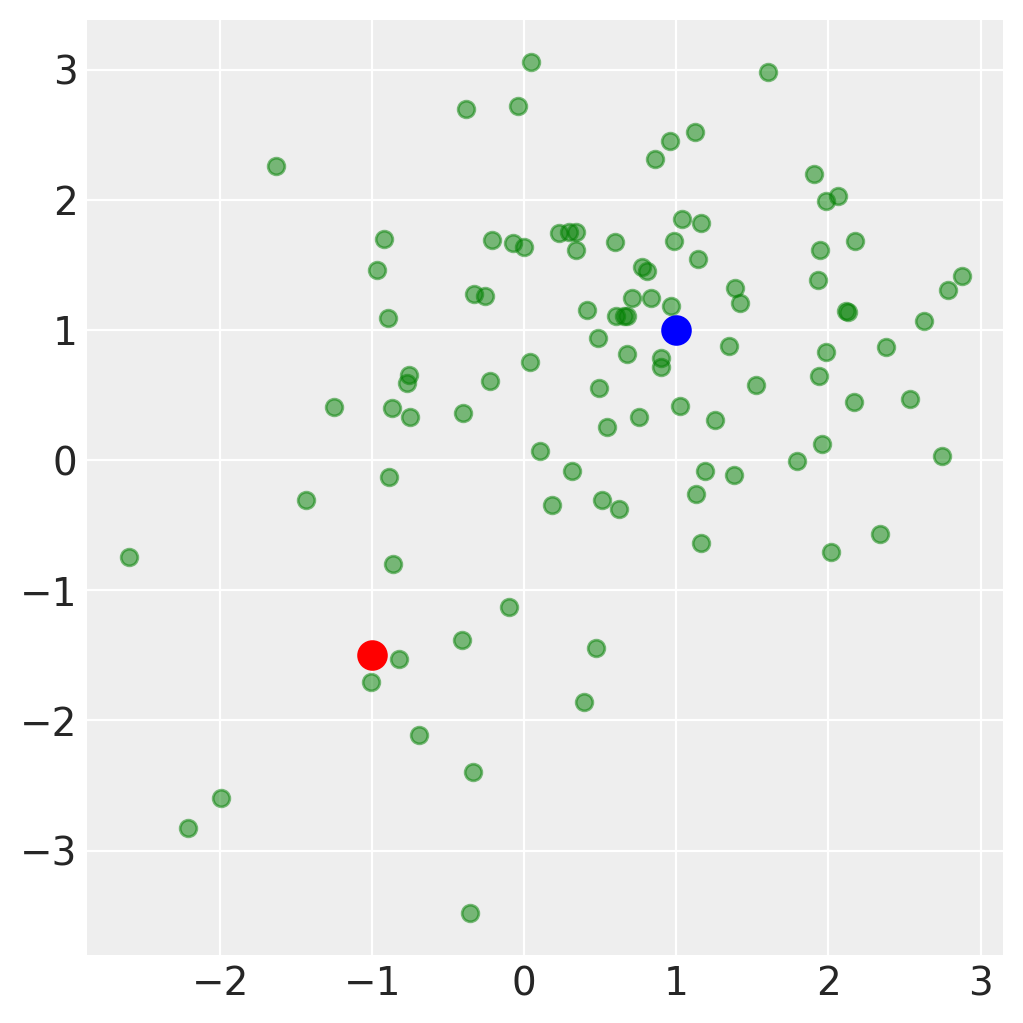

In [3]:
n_samples = 100
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1]])
ps = np.array([0.2, 0.8])

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [
    z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples) for z, m in zip(zs, ms)
]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c="g", alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c="r", s=100)
plt.scatter(ms[1, 0], ms[1, 1], c="b", s=100);

In [4]:
from pymc3.math import logsumexp


# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.0) * (
        k * tt.log(2 * np.pi)
        + tt.log(1.0 / det(tau))
        + (delta(mu).dot(tau) * delta(mu)).sum(axis=1)
    )


# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value) for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_


with pm.Model() as model:
    mus = [
        MvNormal("mu_%d" % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
        for i in range(2)
    ]
    pi = Dirichlet("pi", a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist("x", logp_gmix(mus, pi, np.eye(2)), observed=data)

In [ ]:
with model:
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start)

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [pi]
>Metropolis: [mu_1]
>Metropolis: [mu_0]


In [1]:
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c="g")
mu_0, mu_1 = trace["mu_0"], trace["mu_1"]
plt.scatter(mu_0[:, 0], mu_0[:, 1], c="r", s=10)
plt.scatter(mu_1[:, 0], mu_1[:, 1], c="b", s=10)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

NameError: name 'plt' is not defined

In [ ]:
sns.barplot([1, 2], np.mean(trace["pi"][:], axis=0), palette=["red", "blue"])

In [ ]:
with pm.Model() as model:
    mus = [
        MvNormal("mu_%d" % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
        for i in range(2)
    ]
    pi = Dirichlet("pi", a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist("x", logp_gmix(mus, pi, np.eye(2)), observed=data)

with model:
    %time approx = pm.fit(n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))

means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov) ** 0.5)

In [ ]:
rom copy import deepcopy

mu_0, sd_0 = means["mu_0"], sds["mu_0"]
mu_1, sd_1 = means["mu_1"], sds["mu_1"]


def logp_normal_np(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.0) * (
        k * np.log(2 * np.pi)
        + np.log(1.0 / np.linalg.det(tau))
        + (delta(mu).dot(tau) * delta(mu)).sum(axis=1)
    )


def threshold(zz):
    zz_ = deepcopy(zz)
    zz_[zz < np.max(zz) * 1e-2] = None
    return zz_


def plot_logp_normal(ax, mu, sd, cmap):
    f = lambda value: np.exp(logp_normal_np(mu, np.diag(1 / sd ** 2), value))
    g = lambda mu, sd: np.arange(mu - 3, mu + 3, 0.1)
    xx, yy = np.meshgrid(g(mu[0], sd[0]), g(mu[1], sd[1]))
    zz = f(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).reshape(xx.shape)
    ax.contourf(xx, yy, threshold(zz), cmap=cmap, alpha=0.9)


fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c="g")
plot_logp_normal(ax, mu_0, sd_0, cmap="Reds")
plot_logp_normal(ax, mu_1, sd_1, cmap="Blues")
plt.xlim(-6, 6)
plt.ylim(-6, 6)

In [ ]:
plt.plot(approx.hist)

In [ ]:
n_samples = 100000

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [
    z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples) for z, m in zip(zs, ms)
]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c="g", alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c="r", s=100)
plt.scatter(ms[1, 0], ms[1, 1], c="b", s=100)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

In [ ]:
with pm.Model() as model:
    mus = [
        MvNormal("mu_%d" % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
        for i in range(2)
    ]
    pi = Dirichlet("pi", a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist("x", logp_gmix(mus, pi, np.eye(2)), observed=data)

    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start)

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c="g")
mu_0, mu_1 = trace["mu_0"], trace["mu_1"]
plt.scatter(mu_0[-500:, 0], mu_0[-500:, 1], c="r", s=50)
plt.scatter(mu_1[-500:, 0], mu_1[-500:, 1], c="b", s=50)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

In [ ]:
minibatch_size = 200
# In memory Minibatches for better speed
data_t = pm.Minibatch(data, minibatch_size)

with pm.Model() as model:
    mus = [
        MvNormal("mu_%d" % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
        for i in range(2)
    ]
    pi = Dirichlet("pi", a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist("x", logp_gmix(mus, pi, np.eye(2)), observed=data_t, total_size=len(data))

In [ ]:
# Used only to write the function call in single line for using %time
# is there more smart way?


def f():
    approx = pm.fit(n=1500, obj_optimizer=pm.adagrad(learning_rate=1e-1), model=model)
    means = approx.bij.rmap(approx.mean.eval())
    sds = approx.bij.rmap(approx.std.eval())
    return means, sds, approx.hist


%time means, sds, elbos = f()

In [ ]:
plt.plot(elbos);

# BACK TO REALITY
ups, there goes gravity

## Exercise 4: Getting Dirictlet wit' it 
Repeat exercise 1 using a Dirichlet process.

In [2]:
## START BY SIMULATING DATA:
clusters = 3

n_cluster = [90, 50, 75]
n_total = sum(n_cluster)

means = [9, 21, 35]
std_devs = [2, 2, 2]

mix = np.random.normal(np.repeat(means, n_cluster), np.repeat(std_devs, n_cluster))

<AxesSubplot:>

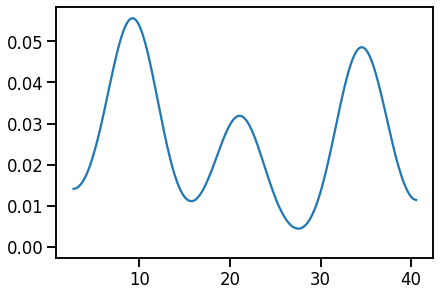

In [3]:
az.plot_kde(mix)

In [4]:
### PREP FOR DIRICTLET:
N = mix.shape[0]
K = 20
def stick_breaking(α):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.],
    tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [5]:
with pm.Model() as model:
    α = pm.Gamma('α', 1., 1.)
    w = pm.Deterministic('w', stick_breaking(α))
    means = pm.Normal('means', mu=mix.mean(), sd=10, shape=K)
    sd = pm.HalfNormal('sd', sd=10, shape=K)
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=mix)
    trace = pm.sample(1000, tune=2000, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, β, α]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 216 seconds.
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7843647319653396, but should be close to 0.9. Try to increase the number of tuning steps.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7557539343538299, but should be close to 0.9. Try to increase the number of tuning steps.
There were 232 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7909763773650517, but should be close to 0.9. Try to increase the number of tuning steps.
There were 177 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estima

Text(0, 0.5, 'Average weight')

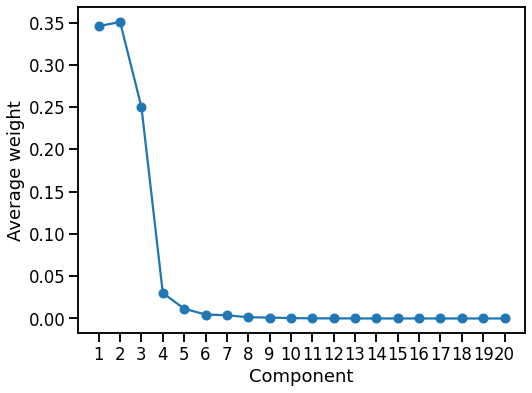

In [6]:
plt.figure(figsize=(8, 6))
plot_w = np.arange(K)
plt.plot(plot_w, trace['w'].mean(0), 'o-')
plt.xticks(plot_w, plot_w+1)
plt.xlabel('Component')
plt.ylabel('Average weight')

array([[<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

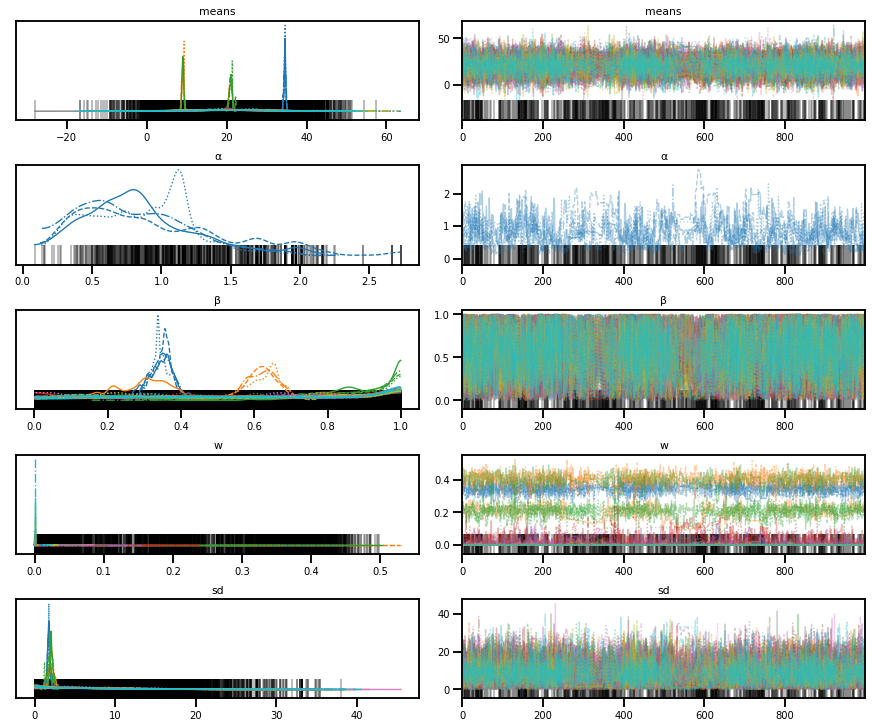

In [16]:
az.plot_trace(trace)

In [14]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, 20)
    idata_pymc3 = az.from_pymc3(trace, posterior_predictive=ppc_trace)

posterior predictive variable obs's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


<AxesSubplot:xlabel='obs'>

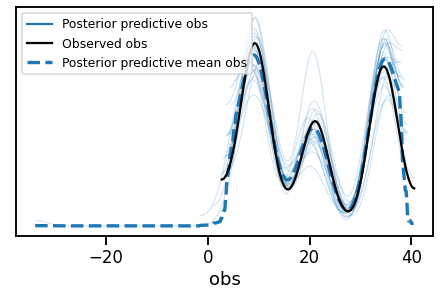

In [15]:
az.plot_ppc(idata_pymc3)

## Exercise 5: Beauty is in the Iris of the Beholder
Assuming for a moment that you do not know the correct species/labels for the
Iris dataset, use a mixture model to cluster the three iris species, using one
feature of your choice (like the length of the sepal).

In [17]:
iris_data = pd.read_csv("../data/iris.csv")
iris_data.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [18]:
clusters = 3
with pm.Model() as model_iris:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=iris_data["sepal_length"].values.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=3)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=iris_data["sepal_length"].values)
    trace_iris = pm.sample(random_seed=123, target_accept = 0.98)
    ppc_trace_iris = pm.sample_posterior_predictive(trace_iris, 500)
    idata_pymc3_iris = az.from_pymc3(trace_iris, posterior_predictive=ppc_trace_iris)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 139 seconds.
The acceptance probability does not match the target. It is 0.9055742976031688, but should be close to 0.98. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


array([[<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

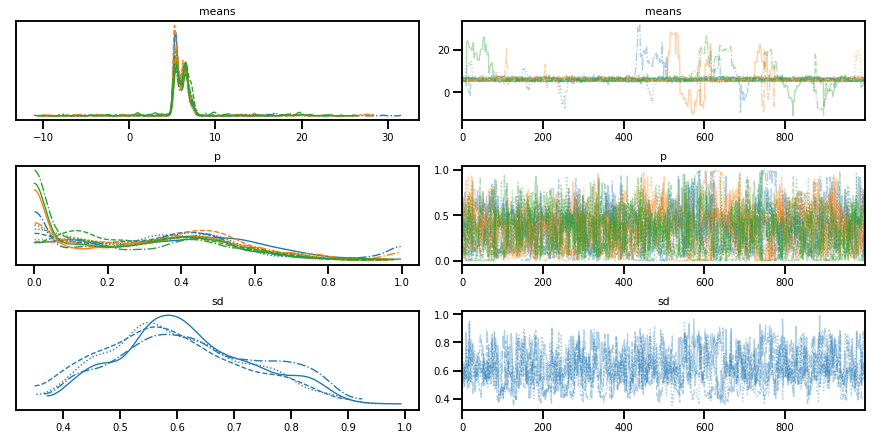

In [19]:
az.plot_trace(trace_iris)

<AxesSubplot:xlabel='y'>

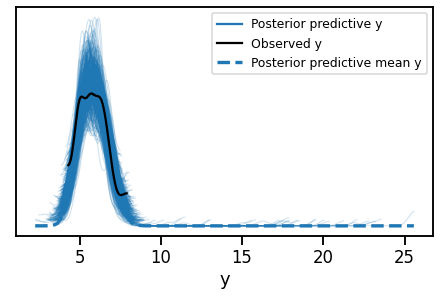

In [20]:
az.plot_ppc(idata_pymc3_iris)

Alternatively:
Instead of stating to our model that we have three different normal distributions, that the data is coming from, we state that instead, we know that there are three different clusters in the data. We therefore try to sample a category for each observation, and assigning it to a group. We estimate that groups mean, and hopefully we can separate our classes. 

That is at least what I am hoping this is doing. Don't know too much about this to be completely honest.

In [43]:
with pm.Model() as model_kg:
    # Each observation is assigned to a cluster/component with probability p
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=len(iris_data["sepal_length"].values)) 
    
    # Known Gaussians means
    means = pm.Normal('means', 
                         mu = np.linspace(iris_data["sepal_length"].values.min(), iris_data["sepal_length"].values.max(), clusters),
                         sd = 5, shape = clusters,
                         transform = pm.distributions.transforms.ordered)
    #means = pm.Normal('means', mu=iris_data["sepal_length"].values.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=3)

    y = pm.Normal('y', mu=means[category], sd=sd, observed=iris_data["sepal_length"].values)

    #step1 = pm.CategoricalGibbsMetropolis(vars=[category], values=range(clusters))
    ## The CategoricalGibbsMetropolis is a recent addition to PyMC3
    ## I have not find the time yet to experiment with it.
    #step1 = pm.CategoricalGibbsMetropolis(vars=[category]) 
    #step2 = pm.Metropolis(vars=[p])
    #trace_kg = pm.sample(10000, step=[step1, step2])
    step1 = pm.CategoricalGibbsMetropolis(vars=[category])
    step2 = pm.NUTS(target_accept = 0.98)
    trace_kg = pm.sample(1000, tune = 3000, step = [step1, step2])
    ppc_trace_iris = pm.sample_posterior_predictive(trace_kg, 500)
    idata_pymc3_iris = az.from_pymc3(trace_kg, posterior_predictive=ppc_trace_iris)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [category]
>NUTS: [sd, means, p]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 320 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9201532830803657, but should be close to 0.98. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


In [44]:
az.summary(trace_kg)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
category[0]  0.305  0.540   0.000    1.000      0.139    0.100      15.0   
category[1]  0.268  0.510   0.000    1.000      0.133    0.096      15.0   
category[2]  0.244  0.492   0.000    1.000      0.126    0.091      15.0   
category[3]  0.224  0.474   0.000    1.000      0.118    0.085      16.0   
category[4]  0.292  0.530   0.000    1.000      0.139    0.100      15.0   
...            ...    ...     ...      ...        ...      ...       ...   
p[2]         0.213  0.163   0.000    0.490      0.053    0.039       9.0   
means[0]     5.221  0.265   4.854    5.720      0.049    0.036      30.0   
means[1]     6.029  0.389   5.303    6.586      0.141    0.104       8.0   
means[2]     7.124  1.405   5.933    7.758      0.316    0.227      20.0   
sd           0.561  0.123   0.375    0.796      0.037    0.027      11.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
category[0]    15.0      14.0      13.0   1.20  
category[1]    15.0      14.0      13.0   1.22  
category[2]    15.0      14.0      13.0   1.21  
category[3]    16.0      15.0      14.0   1.19  
category[4]    15.0      14.0      13.0   1.21  
...             ...       ...       ...    ...  
p[2]            9.0      11.0      28.0   1.29  
means[0]       28.0      27.0      36.0   1.11  
means[1]        8.0       9.0      63.0   1.36  
means[2]       20.0      10.0      24.0   1.33  
sd             11.0      11.0      57.0   1.30  

[157 rows x 11 columns]

array([[<AxesSubplot:title={'center':'category'}>,
        <AxesSubplot:title={'center':'category'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>],
       [<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

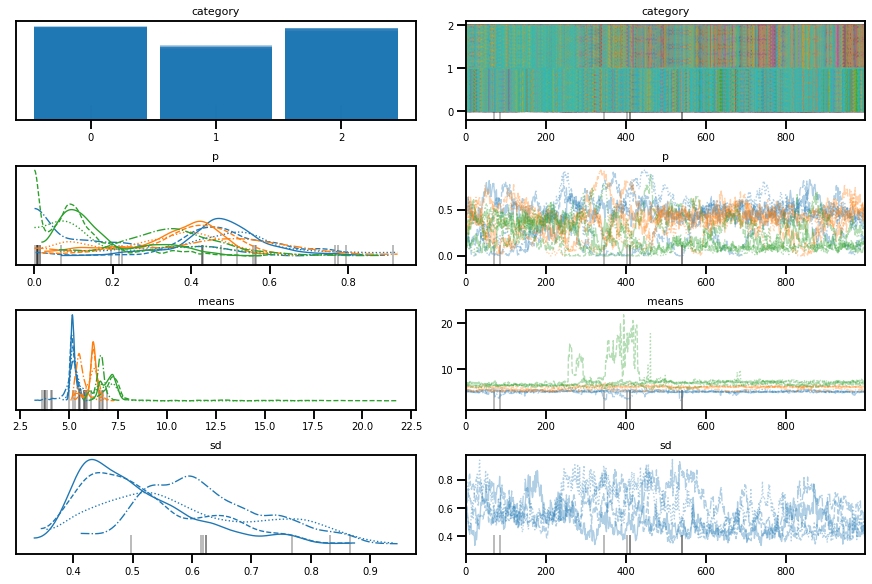

In [45]:
az.plot_trace(trace_kg)

<AxesSubplot:xlabel='y'>

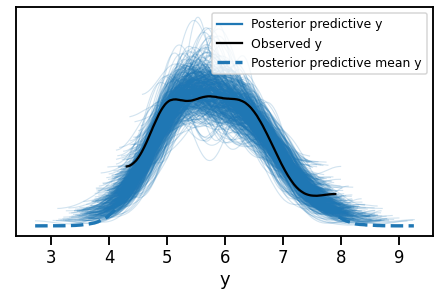

In [46]:
az.plot_ppc(idata_pymc3_iris)

In [47]:
sum_dat = az.summary(trace_kg)

In [53]:
probs = sum_dat["mean"][:len(iris_data)].values

In [64]:
probs[:50].mean()

0.31946

In [65]:
probs[51:100].mean()

0.8102448979591836

In [66]:
probs[101:150].mean()

1.2473469387755103